# Chapter 16: Reinforcement Learning

## Learning to Play Ms. Pac-Man Using the DQN Algorithm

Given a game that can be described using a [Markov Decision Process](https://goo.gl/wZTVIN), e.g. Ms. Pac-Man, we want to train an RL model which can learn what actions the agent can take which will yield the most rewards.

We will do so by training a _deep Q-network_ (DQN) to learn how to approximate the Q-Values of each state-action pair by learning a function to get approximate Q-Values, $Q_\theta (s, a)$, where $\theta$ is the learned model parameters. In this case, the state is the raw pixels of the Pac-Man game and the actions are the 9 directions you can move the joystick.

The model is trained using Gradient Descent where the target Q-Values for each state-action pair is given by

$$ y(s, a) = r \, + \, \gamma \cdot \max_{a'} \, Q_\theta\left(s',a'\right) $$

where

- $r$ is the reward that the agent gets from taking action $a$ when the game is in state $s$.

- $\gamma$ is the discount rate.

For more information about Q-Learning and DQNs, see `ReinforcementLearning.ipynb`.

## Setup



In [0]:
import tensorflow as tf
import numpy as np
import os
import sys

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Creating the Ms. Pac-Man Environment

In [0]:
import gym

env = gym.make('MsPacman-v0')
obs = env.reset()

In [0]:
# (height, width, channels)
obs.shape

(210, 160, 3)

In [0]:
env.action_space

Discrete(9)

## Preprocessing

Since the image for the game state is large and contains RGB channels, we want to define a preprocessing function which will reduce the image's size, make it grayscale, and increase the contrast of Ms. Pac-Man. This will speed up training and reduce the amount of computations the DQN will need to do.

In [0]:
mspacman_color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):
  img = obs[1:176:2, ::2] # crop and downsize
  img = img.mean(axis=2) # convert to grayscale
  img[img == mspacman_color] = 0 # improve contrast
  img = (img - 128) / 128 # normalize values from -1 to 1.
  return img.reshape(88, 80, 1)

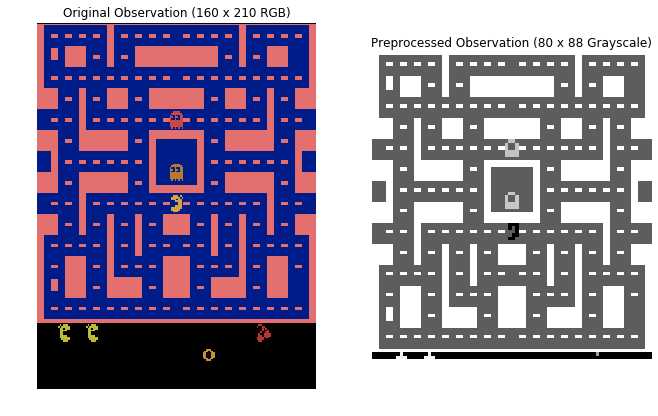

In [0]:
# Plotting the original image and the preprocessed image next to each other.

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title('Original Observation (160 x 210 RGB)')
plt.imshow(obs)
plt.axis('off')
plt.subplot(122)
plt.title('Preprocessed Observation (80 x 88 Grayscale)')
img = preprocess_observation(obs)
plt.imshow(img.reshape(88, 80), interpolation='nearest', cmap='gray')
plt.axis('off')
plt.show()

## Build the DQN

The DQN will be composed of 3 convolutional layers, a hidden fully connected layer, and then finally an output layer with 9 neurons, one for each action.

In [0]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8, 8), (4, 4), (3, 3)]
conv_strides = [4, 2, 1]
conv_paddings = ['SAME'] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n
initializer = tf.contrib.layers.variance_scaling_initializer()

This model actually will use two DQNs. The first is the _online_ DQN which learns and plays after each training iteration. The second is the _target_ DQN which generates the target Q-Values. Every few training iterations, the online DQNs parameters are copied to the target DQN. This technique was introduced by DeepMind.

Below is a function which generates a DQN.

In [0]:
def q_network(X_state, name):
  prev_layer = X_state
  with tf.variable_scope(name) as scope:
    for n_maps, kernel_size, strides, padding, activation in zip(
        conv_n_maps, conv_kernel_sizes, conv_strides, conv_paddings,
        conv_activation):
      prev_layer = tf.layers.conv2d(prev_layer, filters=n_maps,
                                    kernel_size=kernel_size, strides=strides,
                                    padding=padding, activation=activation,
                                    kernel_initializer=initializer)
    flattened = tf.reshape(prev_layer, [-1, n_hidden_in])
    hidden = tf.layers.dense(flattened, n_hidden, activation=hidden_activation,
                             kernel_initializer=initializer)
    outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer=initializer)
  trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     scope=scope.name)
  trainable_vars_by_name = {var.name[len(scope.name):]: var
                            for var in trainable_vars}
  return outputs, trainable_vars_by_name

In [0]:
# Starting the DQN definition.

X_state = tf.placeholder(tf.float32, shape=(None, input_height, input_width,
                                            input_channels))
online_q_values, online_vars = q_network(X_state, 'q_networks/online')
target_q_values, target_vars = q_network(X_state, 'q_networks/target')
copy_ops = [var.assign(online_vars[name]) for name, var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [0]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

Below we define the training operation for the DQN. First, we need to define its computed Q-Value for each state-action pair. Since the neural network produces a Q-Value for each possible action, we will want to input what the actual action the agent took in a one-hot encoded vector, this way we only compute the Q-Value for the action that was taken.

Another modification is that instead of just using MSE for the error, we use a linear error for any loss values less than -1 or greater than 1. This helps training the model since it prevents large loss values from dominating the error gradient.

For training, we use Nesterov Accelerated Gradient Descent to train the model parameters.

In [0]:
learning_rate = 1e-3
momentum = 0.95

with tf.variable_scope('training'):
  X_action = tf.placeholder(tf.int32, shape=(None,))
  y = tf.placeholder(tf.float32, shape=(None, 1))
  q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                          axis=1, keepdims=True)
  error = tf.abs(y - q_value)
  clipped_error = tf.clip_by_value(error, 0.0, 1.0)
  linear_error = 2 * (error - clipped_error)
  loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)
  
  global_step = tf.Variable(0, trainable=False, name='global_step')
  optimizer = tf.train.MomentumOptimizer(learning_rate, momentum,
                                         use_nesterov=True)
  training_op = optimizer.minimize(loss, global_step=global_step)

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

To improve the performance of the model, it will use a _replay memory_ that randomly samples a training batch of past experiences. This increases the variance of the model, helping it generalize better and not correlate the agent's actions with recent replays too strongly. This technique was also developed by DeepMind.

In [0]:
class ReplayMemory(object):
  def __init__(self, maxlen):
    self.maxlen = maxlen
    self.buf = np.empty(shape=maxlen, dtype=np.object)
    self.index = 0
    self.length = 0
    
  def append(self, data):
    self.buf[self.index] = data
    self.length = min(self.length + 1, self.maxlen)
    self.index = (self.index + 1) % self.maxlen
    
  def sample(self, batch_size):
    return self.buf[np.random.randint(self.length, size=batch_size)]

In [0]:
replay_memory_size = 300000
replay_memory = ReplayMemory(replay_memory_size)

In [0]:
def sample_memories(batch_size):
  cols = [[], [], [], [], []] # state, action, reward, next_state, continue
  for memory in replay_memory.sample(batch_size):
    for col, value in zip(cols, memory):
      col.append(value)
  cols = [np.array(col) for col in cols]
  return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], \
      cols[4].reshape(-1, 1)

To allow the model to explore new actions at first then gradually start using the optimal action based on its predicted Q-Value. In order to do so, we will use an $\varepsilon$-greedy policy which starts using random actions and gradually starts using the predicted Q-Value as training progresses.

In [0]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
  epsilon = max(eps_min,
                eps_max - ((eps_max - eps_min) * (step / eps_decay_steps)))
  if np.random.rand() < epsilon:
    return np.random.randint(n_outputs)
  return np.argmax(q_values)

Since I am running my notebook in Colab, where kernels have a maximum lifetime of 12 hours, I will need to save my model to my Drive. This way I can restore the model even if the kernel gets shut down.

In [0]:
from google.colab import drive

drive.mount('/content/gdrive/')

In [0]:
checkpoint_path = '/content/gdrive/My Drive/models/mspacman_dqn.ckpt'

Now we will define the main training loop. The training loop will first play the game for the first few training iterations using the policy defined above. It will append the results of each move to the replay memory to be used when training actually begins. When we start training, we compute the Q-Values that the online DQN predicts and compare them to the target Q-Values. Every so often, we copy the online DQN to the target DQN with updated parameters.

In [0]:
# Some variables for training.

n_steps = 5000000
training_start = 10000
training_interval = 4
save_steps = 1000
copy_steps = 10000
discount_rate = 0.99
skip_start = 90 # Skip the first 90 steps since its just waiting time.
batch_size = 50
iteration = 0
done = True # To reset the environment at the start.

loss_val = np.infty
game_length = 0
total_max_q = 0.0
mean_max_q = 0.0

In [0]:
# The training loop.

with tf.Session() as sess:
  if os.path.isfile(checkpoint_path + '.index'):
    saver.restore(sess, checkpoint_path)
  else:
    init.run()
    copy_online_to_target.run()
  while True:
    step = global_step.eval()
    if step >= n_steps:
      break
    iteration += 1
    print('\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}'
          '\tMean Max-Q {:5f}   '.format(
              iteration, step, n_steps, 100 * step / n_steps, loss_val,
              mean_max_q),
          end='')
    if done:
      obs = env.reset()
      for _ in range(skip_start):
        obs, reward, done, info = env.step(0)
      state = preprocess_observation(obs)
    
    # Evaluate the next action for the agent.
    q_values = online_q_values.eval(feed_dict={X_state: [state]})
    action = epsilon_greedy(q_values, step)
    
    # Online DQN plays the game.
    obs, reward, done, info = env.step(action)
    next_state = preprocess_observation(obs)
    
    # Save the result in the ReplayMemory.
    replay_memory.append((state, action, reward, next_state, 1.0 - done))
    state = next_state
    
    # Statistics to see how training is doing.
    total_max_q += q_values.max()
    game_length += 1
    if done:
      mean_max_q = total_max_q / game_length
      total_max_q = 0.0
      game_length = 0
    
    # Only train after the warmup rounds and only every few rounds.
    if iteration < training_start or iteration % training_interval != 0:
      continue
      
    # Sample memories from the reply memory.
    X_state_val, X_action_val, rewards, X_next_state_val, continues = \
        sample_memories(batch_size)
    next_q_values = target_q_values.eval(feed_dict={X_state: X_next_state_val})
    max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
    y_val = rewards + continues * discount_rate * max_next_q_values
    
    # Train the online DQN.
    _, loss_val = sess.run([training_op, loss],
                           feed_dict={X_state: X_state_val,
                                      X_action: X_action_val,
                                      y: y_val})
    
    # Regularly copy the online DQN to the target DQN.
    if step % copy_steps == 0:
      copy_online_to_target.run()
      
    # Regularly save the model.
    if step % save_steps == 0:
      saver.save(sess, checkpoint_path)

W0830 01:17:48.658392 140309637019520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Iteration 869992	Training step 4999999/5000000 (100.0)%	Loss 10.134315	Mean Max-Q 199.644844   

The code below plays a game using the trained DQN, then plots the animation of the game as a video.

In [0]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
  saver.restore(sess, checkpoint_path)
  
  obs = env.reset()
  for step in range(n_max_steps):
    state = preprocess_observation(obs)
    
    q_values = online_q_values.eval(feed_dict={X_state: [state]})
    action = np.argmax(q_values)
    
    obs, reward, done, info = env.step(action)
    
    img = env.render(mode='rgb_array')
    frames.append(img)
    
    if done:
      break

In [0]:
from IPython.display import HTML

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
  plt.close()
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                 frames=len(frames), repeat=repeat,
                                 interval=interval)
  return HTML(anim.to_html5_video())

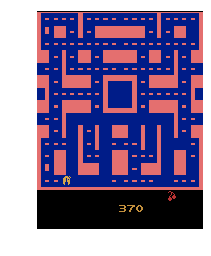

In [0]:
plot_animation(frames)